In [1]:
# --- INSTALLS ---
!pip install diffusers transformers accelerate torch torchvision torchaudio sentence-transformers faiss-cpu bitsandbytes peft --quiet
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 61.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylib

In [2]:
# --- IMPORTS ---
import os
import glob
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from datasets import Dataset
from torchvision import transforms
from sentence_transformers import SentenceTransformer
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from huggingface_hub import login
import faiss
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

2025-04-26 13:54:20.872820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745675661.046679      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745675661.094799      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# --- CONFIG ---
dataset_root = "/kaggle/input/best-artworks-of-all-time/images/images"
description_root = "/kaggle/input/description-of-the-paintings-best-artworks"
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
base_model_name = "dreamlike-art/dreamlike-diffusion-1.0"  # 🎨 Much better for art

In [4]:
# --- LOGIN TO HF IF NEEDED ---
login()  # 🔐

In [5]:
# --- EMBEDDING MODEL ---
embedding_model = SentenceTransformer(embedding_model_name).to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# --- DIFFUSION PIPELINE (Load Base Model) ---
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    use_safetensors=True,
).to(device)


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [8]:
# --- LOAD IMAGE/DESCRIPTION PAIRS ---
def get_image_description_pairs():
    desc_map = {}
    for folder in ['descriptions1', 'descriptions2', 'descriptions (5)']:
        desc_files = glob.glob(f"{description_root}/{folder}/*.txt")
        for fpath in desc_files:
            fname = os.path.basename(fpath).split('.')[0]
            with open(fpath, 'r', encoding='utf-8') as f:
                desc_map[fname] = f.read().strip()

    pairs = []
    folders = sorted(os.listdir(dataset_root))
    for folder in folders:
        full_path = os.path.join(dataset_root, folder)
        for img_path in glob.glob(f"{full_path}/*.jpg"):
            fname = os.path.basename(img_path).split('.')[0]
            if fname in desc_map:
                pairs.append((img_path, desc_map[fname]))
    return pairs

In [9]:
pairs = get_image_description_pairs()
print(f"✅ Found {len(pairs)} image/description pairs.")

✅ Found 8708 image/description pairs.


In [10]:
# --- PREPARE DATASET ---
def prepare_dataset(pairs):
    data = []
    for img_path, desc in pairs:
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = image_transform(img)
            data.append({"image": img_tensor, "chunk": desc, "path": img_path})
        except Exception as e:
            print(f"⚠️ {img_path} failed: {e}")
    return Dataset.from_list(data)

In [11]:
dataset = prepare_dataset(pairs)

In [12]:
# --- FAISS INDEX ---
print("📚 Building FAISS index...")
desc_embeds = embedding_model.encode(dataset["chunk"], convert_to_numpy=True, show_progress_bar=True)
index = faiss.IndexFlatL2(desc_embeds.shape[1])
index.add(desc_embeds)

📚 Building FAISS index...


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

In [13]:
# --- RETRIEVAL ---
def retrieve_similar_chunks(query, top_k=5):
    query_emb = embedding_model.encode([query])
    D, I = index.search(query_emb, top_k)
    return [dataset[int(i)]["chunk"] for i in I[0]]

In [14]:
# --- SMART PROMPT FUSION ---
def create_final_prompt(user_prompt, artist_name, retrieved_chunks):
    # Slightly smarter: diversify phrases, add creative linking
    style_descriptions = ". ".join(random.sample(retrieved_chunks, min(4, len(retrieved_chunks))))
    final_prompt = (
        f"{user_prompt}, captured in the essence of {artist_name}'s style. "
        f"Emphasized artistic traits include: {style_descriptions}."
    )
    return final_prompt

In [15]:
# --- GENERATE IMAGE ---
def generate_image(user_prompt, artist_name, show=True):
    retrieved_chunks = retrieve_similar_chunks(artist_name)
    final_prompt = create_final_prompt(user_prompt, artist_name, retrieved_chunks)
    
    with torch.no_grad():
        image = pipe(final_prompt).images[0]
    
    if show:
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"🎨 {artist_name} Style")
        plt.show()
    
    return image, final_prompt

In [16]:
# --- LORA FINE-TUNING SETUP (OPTIONAL) ---
def prepare_lora(pipe):
    # PEFT LoRA config for fine-tuning U-Net
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["cross_attn", "attn1", "attn2"],  # focus on attention layers
        lora_dropout=0.1,
        bias="none",
        task_type="UNET"
    )
    unet = pipe.unet
    unet = prepare_model_for_kbit_training(unet)
    lora_unet = get_peft_model(unet, lora_config)
    print(lora_unet.print_trainable_parameters())
    return lora_unet

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (219 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['leonardo _ da _ vinci _ 8 2 . jpg description : renaissance painting , symmetrical composition , muted colors , delicate brushwork , serene atmosphere , figures in classical drapery in a garden setting .. image : leonardo _ da _ vinci _ 1 2 1 . jpg description : renaissance portrait , soft sfumato , muted earthy tones , serene and enigmatic expression , subtle gradations of light and shadow , smooth brushstrokes , landscape background fading into atmospheric perspective .. image : leonardo _ da _ vinci _ 2 5 . jpg description : renaissance style portrait sketch . soft pencil lines , muted sepia tones , on aged paper . focused , gentle expression . fine , detailed shading capturing light and shadow . seren

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


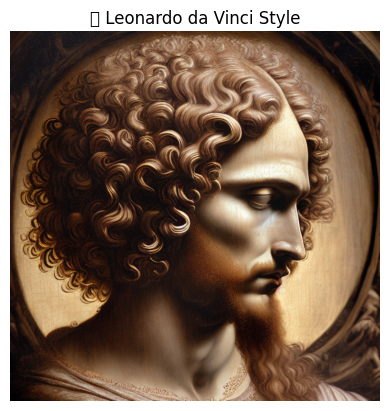

📝 Final Prompt:
 A majestic tree with intricate details, captured in the essence of Leonardo da Vinci's style. Emphasized artistic traits include: Image: Leonardo_da_Vinci_52.jpg
Description: Renaissance portrait, chiaroscuro lighting, subtle brushstrokes, muted earthy tones, contemplative mood, side view, with details of fine curly hair and soft skin texture.. Image: Leonardo_da_Vinci_82.jpg
Description: Renaissance painting, symmetrical composition, muted colors, delicate brushwork, serene atmosphere, figures in classical drapery in a garden setting.. Image: Leonardo_da_Vinci_121.jpg
Description: Renaissance portrait, soft sfumato, muted earthy tones, serene and enigmatic expression, subtle gradations of light and shadow, smooth brushstrokes, landscape background fading into atmospheric perspective.. Image: Leonardo_da_Vinci_25.jpg
Description: Renaissance style portrait sketch. Soft pencil lines, muted sepia tones, on aged paper. Focused, gentle expression. Fine, detailed shading ca

In [17]:
# --- TESTING EXAMPLES ---
user_prompt = "A majestic tree with intricate details"
artist_name = "Leonardo da Vinci"
image, prompt_used = generate_image(user_prompt, artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/tree_leonardo_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['toulouse - lautrec _ 2 4 . jpg description : oil painting portrait , impressionistic style , textured brushstrokes , muted palette of browns and reds , relaxed pose , introspective mood .. image : henri _ de _ toulouse - lautrec _ 1 0 . jpg description : portrait in the style of post - impressionism , oil on canvas , with visible brushstrokes creating texture , a warm color palette dominated by yellows and browns , moody and introspective , depicting a figure partially obscured by shadow , creating a sense of mystery and quiet contemplation .. image : henri _ rousseau _ 6 2 . jpg description : naive art style , overcast cityscape , somber mood , muted earthy tones , flat perspective , visible brushstrokes , simplified geometric forms , figures with obscured faces , a sense of quiet and solitude ..']


  0%|          | 0/50 [00:00<?, ?it/s]

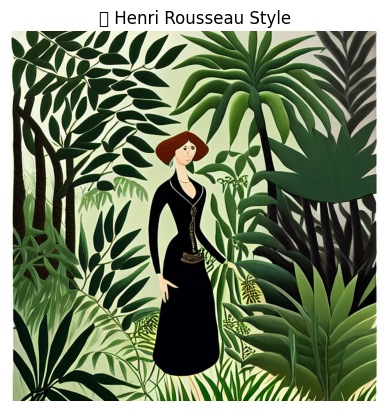

📝 Final Prompt:
 An elegant woman standing in a lush jungle, captured in the essence of Henri Rousseau's style. Emphasized artistic traits include: Image: Henri_Rousseau_42.jpg
Description: Naive art style, melancholic mood, muted greens and grays, smooth brushstrokes, symmetrical composition, figures in black suits in a landscape.. Image: Henri_de_Toulouse-Lautrec_24.jpg
Description: Oil painting portrait, impressionistic style, textured brushstrokes, muted palette of browns and reds, relaxed pose, introspective mood.. Image: Henri_de_Toulouse-Lautrec_10.jpg
Description: Portrait in the style of post-impressionism, oil on canvas, with visible brushstrokes creating texture, a warm color palette dominated by yellows and browns, moody and introspective, depicting a figure partially obscured by shadow, creating a sense of mystery and quiet contemplation.. Image: Henri_Rousseau_62.jpg
Description: Naive art style, overcast cityscape, somber mood, muted earthy tones, flat perspective, visib

In [18]:
user_prompt = "An elegant woman standing in a lush jungle"
artist_name = "Henri Rousseau"
image, prompt_used = generate_image(user_prompt, artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/woman_rousseau_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['amedeo _ modigliani _ 6 8 . jpg description : portrait in a naive style , elongated face , smooth brushstrokes , muted pastel colors , melancholic mood .. image : mikhail _ vrubel _ 5 2 . jpg description : portrait in a watercolor style , muted and melancholic colors , loose brushstrokes and visible pencil lines , close - up view , introspective mood .. image : kazimir _ malevich _ 3 0 . jpg description : suprematist painting , central square on off - white background , layered matte textures , minimalist , geometric abstraction ..']


  0%|          | 0/50 [00:00<?, ?it/s]

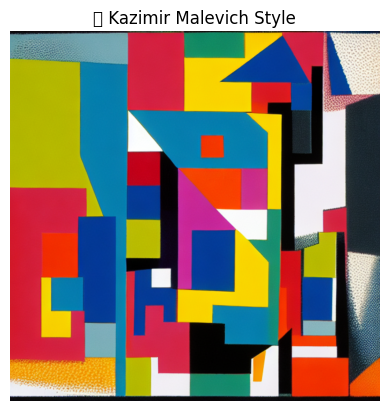

📝 Final Prompt:
 An abstract composition of colorful geometric shapes, captured in the essence of Kazimir Malevich's style. Emphasized artistic traits include: Image: Kazimir_Malevich_17.jpg
Description: Expressionist portrait, vibrant and clashing colors, angular and distorted features, thick and visible brushstrokes, conveying intensity and unease.. Image: Amedeo_Modigliani_68.jpg
Description: Portrait in a naive style, elongated face, smooth brushstrokes, muted pastel colors, melancholic mood.. Image: Mikhail_Vrubel_52.jpg
Description: Portrait in a watercolor style, muted and melancholic colors, loose brushstrokes and visible pencil lines, close-up view, introspective mood.. Image: Kazimir_Malevich_30.jpg
Description: Suprematist painting, central square on off-white background, layered matte textures, minimalist, geometric abstraction..


In [19]:
# --- TESTING ---
user_prompt = "An abstract composition of colorful geometric shapes"
artist_name = "Kazimir Malevich"
image, prompt_used = generate_image(user_prompt, artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/abstract_malevich_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['image : gustave _ courbet _ 2 6 . jpg description : portrait in the style of dramatic realism , dark earthy tones of brown and umber , visible brushstrokes , chiaroscuro lighting , conveying deep concentration and melancholy .. image : henri _ de _ toulouse - lautrec _ 7 7 . jpg description : late 1 9 th century illustration . quick , loose brushstrokes in warm yellows , oranges , and browns . depicting a crowded interior scene with figures in shadow and bright light . focus on capturing movement and atmosphere .. image : gustave _ courbet _ 4 1 . jpg description : portrait in the realist style , muted earthy tones , loose brushstrokes , diffused lighting , serene mood , full - body composition against a blurred natural background ..']


  0%|          | 0/50 [00:00<?, ?it/s]

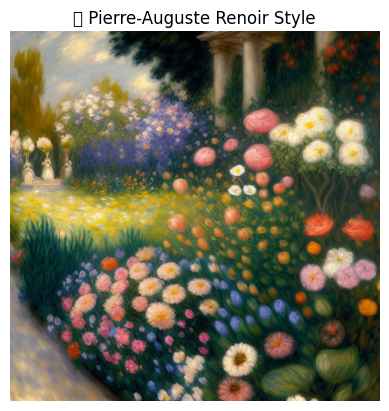

📝 Final Prompt:
 A lush garden with vibrant flowers and soft lighting, captured in the essence of Pierre-Auguste Renoir's style. Emphasized artistic traits include: Image: Gustave_Courbet_59.jpg
Description: Realist portrait painting, close-up, dramatic lighting, panicked expression, impasto brushstrokes, muted earthy tones, stark contrasts, intense emotion.. Image: Gustave_Courbet_26.jpg
Description: Portrait in the style of dramatic realism, dark earthy tones of brown and umber, visible brushstrokes, chiaroscuro lighting, conveying deep concentration and melancholy.. Image: Henri_de_Toulouse-Lautrec_77.jpg
Description: Late 19th century illustration. Quick, loose brushstrokes in warm yellows, oranges, and browns. Depicting a crowded interior scene with figures in shadow and bright light. Focus on capturing movement and atmosphere.. Image: Gustave_Courbet_41.jpg
Description: Portrait in the Realist style, muted earthy tones, loose brushstrokes, diffused lighting, serene mood, full-bod

In [20]:
# --- TESTING ---
user_prompt = "A lush garden with vibrant flowers and soft lighting"
artist_name = "Pierre-Auguste Renoir"
image, prompt_used = generate_image(user_prompt, artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/garden_renoir_style.png")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['image : mikhail _ vrubel _ 5 1 . jpg description : portrait in tonalism style , dark and moody atmosphere , charcoal sketch aesthetic , loose and gestural strokes , hints of red and orange , evoking nostalgia and introspection .. image : diego _ velazquez _ 4 6 . jpg description : portrait in the style of baroque , dark and muted tones , loose brushstrokes , a single figure with a dark backdrop , intense gaze .. image : gustave _ courbet _ 5 9 . jpg description : realist portrait painting , close - up , dramatic lighting , panicked expression , impasto brushstrokes , muted earthy tones , stark contrasts , intense emotion ..']


  0%|          | 0/50 [00:00<?, ?it/s]

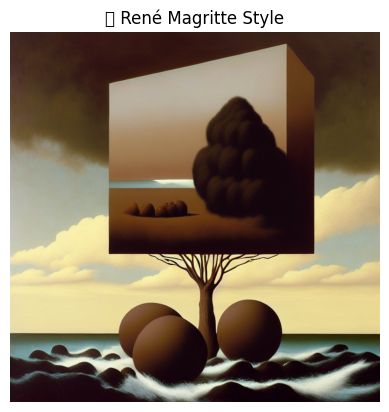

📝 Final Prompt:
 A mysterious dreamscape filled with floating objects, captured in the essence of René Magritte's style. Emphasized artistic traits include: Image: Gustave_Courbet_26.jpg
Description: Portrait in the style of dramatic realism, dark earthy tones of brown and umber, visible brushstrokes, chiaroscuro lighting, conveying deep concentration and melancholy.. Image: Mikhail_Vrubel_51.jpg
Description: Portrait in tonalism style, dark and moody atmosphere, charcoal sketch aesthetic, loose and gestural strokes, hints of red and orange, evoking nostalgia and introspection.. Image: Diego_Velazquez_46.jpg
Description: Portrait in the style of baroque, dark and muted tones, loose brushstrokes, a single figure with a dark backdrop, intense gaze.. Image: Gustave_Courbet_59.jpg
Description: Realist portrait painting, close-up, dramatic lighting, panicked expression, impasto brushstrokes, muted earthy tones, stark contrasts, intense emotion..


In [21]:
# --- TESTING ---
user_prompt = "A mysterious dreamscape filled with floating objects"
artist_name = "René Magritte"
image, prompt_used = generate_image(user_prompt, artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/dream_magritte_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['detail , high - angle perspective , wide - angle view .. image : hieronymus _ bosch _ 5 5 . jpg description : a bosch - style painting of human figures in a desolate landscape , rendered with rough , textured brushstrokes . the color palette is muted and earthy , dominated by browns and ochres . the mood is somber and unsettling , conveying a sense of existential dread . figures are distorted and anatomically incorrect , set against a dark , unfocused background .. image : hieronymus _ bosch _ 4 3 . jpg description : northern renaissance painting . vertical composition , panoramic view . figures engaged in bizarre activities amidst a landscape with murky greens and yellows . oil painting texture with visible brushstrokes and distorted perspective . a mood of strange merriment .. image : hieronymus _ bosch _ 9 0 . jpg description : renaissance portrait , side profile , aged skin text

  0%|          | 0/50 [00:00<?, ?it/s]

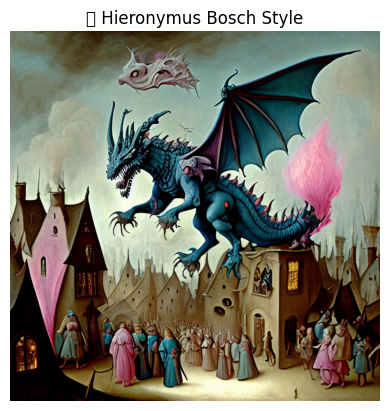

📝 Final Prompt:
 A dragon soaring over a burning village, captured in the essence of Hieronymus Bosch's style. Emphasized artistic traits include: Image: Hieronymus_Bosch_39.jpg
Description: Northern Renaissance style, fantastical procession of bizarre hybrid creatures, muted earth tones with pops of pink and blue, oil on panel texture, dreamlike and unsettling mood, intricate detail, high-angle perspective, wide-angle view.. Image: Hieronymus_Bosch_55.jpg
Description: A Bosch-style painting of human figures in a desolate landscape, rendered with rough, textured brushstrokes. The color palette is muted and earthy, dominated by browns and ochres. The mood is somber and unsettling, conveying a sense of existential dread. Figures are distorted and anatomically incorrect, set against a dark, unfocused background.. Image: Hieronymus_Bosch_43.jpg
Description: Northern Renaissance painting. Vertical composition, panoramic view. Figures engaged in bizarre activities amidst a landscape with mur

In [22]:
# --- TESTING WEIRD + FANTASY STYLE ---

# 1. A dragon soaring over a burning village
artist_name = "Hieronymus Bosch"
image, prompt_used = generate_image("A dragon soaring over a burning village", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/dragon_bosch_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['moody and introspective , depicting a figure partially obscured by shadow , creating a sense of mystery and quiet contemplation .. image : claude _ monet _ 8 . jpg description : impressionistic landscape , muted blues and greens , thick brushstrokes creating texture , a field of wildflowers beneath a cloudy sky , evoking a sense of tranquil nature .. image : henri _ de _ toulouse - lautrec _ 7 2 . jpg description : impressionistic painting of a figure in motion , blurred background , soft palette of greens , yellows and browns , visible brushstrokes , sense of fleeting movement .. image : edouard _ manet _ 3 1 . jpg description : portrait in the impressionist style , muted palette of grays and blacks , soft brushstrokes , hazy background , capturing a serene and contemplative mood ..']


  0%|          | 0/50 [00:00<?, ?it/s]

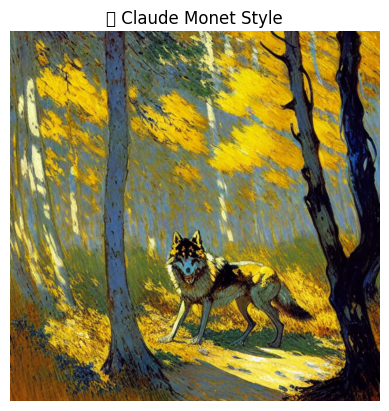

📝 Final Prompt:
 An ancient forest inhabited by luminous wolves, captured in the essence of Claude Monet's style. Emphasized artistic traits include: Image: Henri_de_Toulouse-Lautrec_10.jpg
Description: Portrait in the style of post-impressionism, oil on canvas, with visible brushstrokes creating texture, a warm color palette dominated by yellows and browns, moody and introspective, depicting a figure partially obscured by shadow, creating a sense of mystery and quiet contemplation.. Image: Claude_Monet_8.jpg
Description: Impressionistic landscape, muted blues and greens, thick brushstrokes creating texture, a field of wildflowers beneath a cloudy sky, evoking a sense of tranquil nature.. Image: Henri_de_Toulouse-Lautrec_72.jpg
Description: Impressionistic painting of a figure in motion, blurred background, soft palette of greens, yellows and browns, visible brushstrokes, sense of fleeting movement.. Image: Edouard_Manet_31.jpg
Description: Portrait in the impressionist style, muted pa

In [23]:
# 2. An ancient forest inhabited by luminous wolves
artist_name = "Claude Monet"
image, prompt_used = generate_image("An ancient forest inhabited by luminous wolves", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/luminous_wolves_monet_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['edouard _ manet _ 6 0 . jpg description : classical painting , dark and melancholic mood , visible brushstrokes , muted colors , figure lying diagonally across the canvas , dramatic lighting , shadows .. image : diego _ velazquez _ 7 8 . jpg description : classical portraiture , somber mood , dark earth tones , loose brushstrokes , blurred edges , high contrast , thoughtful expression , plain background .. image : marc _ chagall _ 1 6 2 . jpg description : monochromatic cubist scene , various subjects , sharp geometric facets , ethereal and otherworldly mood , composed in shades of blue , swirling clouds at the bottom , classical figurative elements ..']


  0%|          | 0/50 [00:00<?, ?it/s]

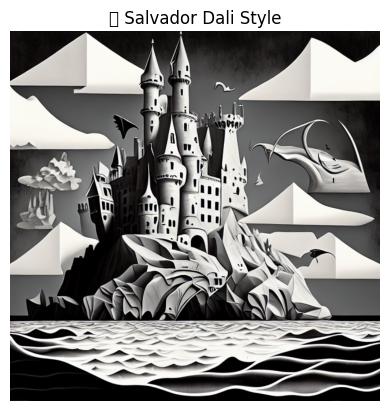

📝 Final Prompt:
 A surreal castle floating above the sea, captured in the essence of Salvador Dali's style. Emphasized artistic traits include: Image: Pablo_Picasso_316.jpg
Description: Cubist portrait, muted grayscale palette, geometric shapes and planes, bold black outlines, textured brushstrokes, melancholic mood, fragmented form, distorted perspective.. Image: Edouard_Manet_60.jpg
Description: Classical painting, dark and melancholic mood, visible brushstrokes, muted colors, figure lying diagonally across the canvas, dramatic lighting, shadows.. Image: Diego_Velazquez_78.jpg
Description: Classical portraiture, somber mood, dark earth tones, loose brushstrokes, blurred edges, high contrast, thoughtful expression, plain background.. Image: Marc_Chagall_162.jpg
Description: Monochromatic cubist scene, various subjects, sharp geometric facets, ethereal and otherworldly mood, composed in shades of blue, swirling clouds at the bottom, classical figurative elements..


In [24]:
# 3. A surreal castle floating above the sea
artist_name = "Salvador Dali"
image, prompt_used = generate_image("A surreal castle floating above the sea", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/floating_castle_dali_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [': henri _ de _ toulouse - lautrec _ 7 7 . jpg description : late 1 9 th century illustration . quick , loose brushstrokes in warm yellows , oranges , and browns . depicting a crowded interior scene with figures in shadow and bright light . focus on capturing movement and atmosphere .. image : gustave _ courbet _ 4 1 . jpg description : portrait in the realist style , muted earthy tones , loose brushstrokes , diffused lighting , serene mood , full - body composition against a blurred natural background .. image : gustave _ courbet _ 2 6 . jpg description : portrait in the style of dramatic realism , dark earthy tones of brown and umber , visible brushstrokes , chiaroscuro lighting , conveying deep concentration and melancholy ..']


  0%|          | 0/50 [00:00<?, ?it/s]

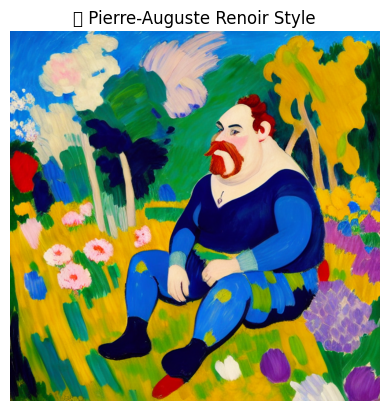

📝 Final Prompt:
 A giant ogre sitting peacefully in a flowery field, captured in the essence of Pierre-Auguste Renoir's style. Emphasized artistic traits include: Image: Henri_Matisse_158.jpg
Description: Abstract expressionist portrait, vibrant and energetic, thick impasto brushstrokes, vivid primary colors with secondary hues, loose composition, emotional intensity.. Image: Henri_de_Toulouse-Lautrec_77.jpg
Description: Late 19th century illustration. Quick, loose brushstrokes in warm yellows, oranges, and browns. Depicting a crowded interior scene with figures in shadow and bright light. Focus on capturing movement and atmosphere.. Image: Gustave_Courbet_41.jpg
Description: Portrait in the Realist style, muted earthy tones, loose brushstrokes, diffused lighting, serene mood, full-body composition against a blurred natural background.. Image: Gustave_Courbet_26.jpg
Description: Portrait in the style of dramatic realism, dark earthy tones of brown and umber, visible brushstrokes, chiar

In [25]:
# 4. A giant ogre sitting peacefully in a flowery field
artist_name = "Pierre-Auguste Renoir"
image, prompt_used = generate_image("A giant ogre sitting peacefully in a flowery field", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/ogre_flowery_renoir_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["aggio _ 1 0 . jpg description : renaissance - style portrait of two figures , soft lighting , warm earthy tones , delicate brushstrokes creating a slightly blurred , dreamlike quality . depict subtle textures and highlights , with attention to the subjects ' expressions and attire . conveys a sense of quiet formality and restrained emotion .. image : caravaggio _ 1 6 . jpg description : baroque - style portrait of a figure in shadow , dramatic chiaroscuro lighting , earthy tones with highlights , conveying introspection and melancholy . visible brushstrokes , close - up , asymmetrical composition , rich fabrics and textures .. image : caravaggio _ 1 4 . jpg description : baroque portrait , dark and muted palette , chiaroscuro lighting , textured brushstrokes , a contemplative mood , medium shot .."]


  0%|          | 0/50 [00:00<?, ?it/s]

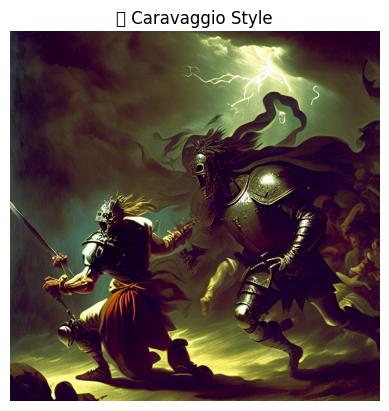

📝 Final Prompt:
 A knight battling a shadow monster in a storm, captured in the essence of Caravaggio's style. Emphasized artistic traits include: Image: Caravaggio_12.jpg
Description: Baroque painting, dramatic chiaroscuro, deep shadows engulfing the scene, spotlight on figures, muted earthy tones, oil on canvas texture, intense emotion, theatrical composition.. Image: Caravaggio_10.jpg
Description: Renaissance-style portrait of two figures, soft lighting, warm earthy tones, delicate brushstrokes creating a slightly blurred, dreamlike quality. Depict subtle textures and highlights, with attention to the subjects' expressions and attire. Conveys a sense of quiet formality and restrained emotion.. Image: Caravaggio_16.jpg
Description: Baroque-style portrait of a figure in shadow, dramatic chiaroscuro lighting, earthy tones with highlights, conveying introspection and melancholy. Visible brushstrokes, close-up, asymmetrical composition, rich fabrics and textures.. Image: Caravaggio_14.jp

In [26]:
# 6. A knight battling a shadow monster in a storm
artist_name = "Caravaggio"
image, prompt_used = generate_image("A knight battling a shadow monster in a storm", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/knight_shadow_caravaggio_style.png")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['marc _ chagall _ 2 8 . jpg description : stylized black and white ink drawing . distorted perspective with dreamlike , floating figures . sketchy , textured lines and stippled shading . simplistic background . surreal and introspective mood .. image : marc _ chagall _ 5 6 . jpg description : portrait in an expressive post - impressionist style , featuring bold , visible brushstrokes and flattened perspective ; a red dress with white lace , and a muted color palette , evoking a sense of quiet contemplation .. image : marc _ chagall _ 2 3 4 . jpg description : woodcut - style illustration , black and white , figures outlined with bold lines , textured shading , folk art , slightly distorted perspective , somber mood ..']


  0%|          | 0/50 [00:00<?, ?it/s]

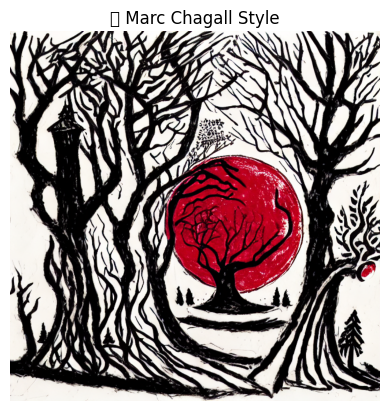

📝 Final Prompt:
 A labyrinth made of living trees under a blood-red moon, captured in the essence of Marc Chagall's style. Emphasized artistic traits include: Image: Marc_Chagall_236.jpg
Description: Expressive monochrome portrait. Bold, smudged charcoal lines on textured paper. Simple composition, conveying a sense of introspection and rustic character.. Image: Marc_Chagall_28.jpg
Description: Stylized black and white ink drawing. Distorted perspective with dreamlike, floating figures. Sketchy, textured lines and stippled shading. Simplistic background. Surreal and introspective mood.. Image: Marc_Chagall_56.jpg
Description: Portrait in an expressive post-impressionist style, featuring bold, visible brushstrokes and flattened perspective; a red dress with white lace, and a muted color palette, evoking a sense of quiet contemplation.. Image: Marc_Chagall_234.jpg
Description: Woodcut-style illustration, black and white, figures outlined with bold lines, textured shading, folk art, sligh

In [27]:
# 7. A labyrinth made of living trees under a blood-red moon
artist_name = "Marc Chagall"
image, prompt_used = generate_image("A labyrinth made of living trees under a blood-red moon", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/labyrinth_trees_chagall_style.png")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['fleeting movement .. image : henri _ de _ toulouse - lautrec _ 2 4 . jpg description : oil painting portrait , impressionistic style , textured brushstrokes , muted palette of browns and reds , relaxed pose , introspective mood .. image : henri _ de _ toulouse - lautrec _ 1 0 . jpg description : portrait in the style of post - impressionism , oil on canvas , with visible brushstrokes creating texture , a warm color palette dominated by yellows and browns , moody and introspective , depicting a figure partially obscured by shadow , creating a sense of mystery and quiet contemplation .. image : vincent _ van _ gogh _ 8 7 1 . jpg description : monochromatic sketch of a standing figure , rendered in dense , parallel hatching . soft , muted tones . captures a somber and contemplative mood . full body shot , simple composition ..']


  0%|          | 0/50 [00:00<?, ?it/s]

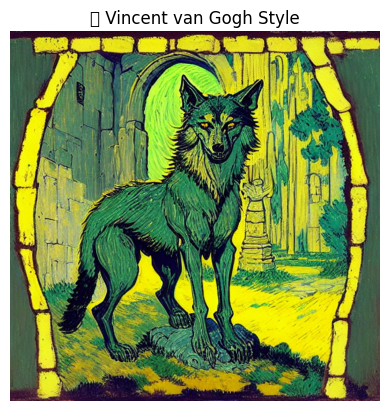

📝 Final Prompt:
 A two-headed wolf guarding an ancient portal, captured in the essence of Vincent van Gogh's style. Emphasized artistic traits include: Image: Henri_de_Toulouse-Lautrec_72.jpg
Description: Impressionistic painting of a figure in motion, blurred background, soft palette of greens, yellows and browns, visible brushstrokes, sense of fleeting movement.. Image: Henri_de_Toulouse-Lautrec_24.jpg
Description: Oil painting portrait, impressionistic style, textured brushstrokes, muted palette of browns and reds, relaxed pose, introspective mood.. Image: Henri_de_Toulouse-Lautrec_10.jpg
Description: Portrait in the style of post-impressionism, oil on canvas, with visible brushstrokes creating texture, a warm color palette dominated by yellows and browns, moody and introspective, depicting a figure partially obscured by shadow, creating a sense of mystery and quiet contemplation.. Image: Vincent_van_Gogh_871.jpg
Description: Monochromatic sketch of a standing figure, rendered in de

In [28]:
# 8. A two-headed wolf guarding an ancient portal
artist_name = "Vincent van Gogh"
image, prompt_used = generate_image("A two-headed wolf guarding an ancient portal", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/two_headed_wolf_vangogh_style.png")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [': pablo _ picasso _ 3 0 8 . jpg description : portrait in blues : somber , melancholic atmosphere ; simplified forms , thick impasto brushstrokes , limited palette , introspection .. image : pablo _ picasso _ 4 2 1 . jpg description : cubist portrait with geometric forms , rendered in ochre , gray and brown hues . simplified facial features and exaggerated anatomical shapes . visible brushstrokes with a matte texture . symmetrical composition suggesting monumentality and a hint of melancholy .. image : pablo _ picasso _ 3 1 9 . jpg description : portrait in the style of cubism , muted blues and browns , fragmented shapes , visible brushstrokes , melancholic mood , strong outlines , and a dreamlike quality ..']


  0%|          | 0/50 [00:00<?, ?it/s]

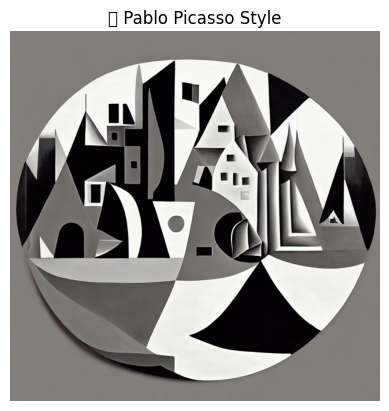

📝 Final Prompt:
 A mystical river flowing through a floating city, captured in the essence of Pablo Picasso's style. Emphasized artistic traits include: Image: Pablo_Picasso_316.jpg
Description: Cubist portrait, muted grayscale palette, geometric shapes and planes, bold black outlines, textured brushstrokes, melancholic mood, fragmented form, distorted perspective.. Image: Pablo_Picasso_308.jpg
Description: Portrait in blues: somber, melancholic atmosphere; simplified forms, thick impasto brushstrokes, limited palette, introspection.. Image: Pablo_Picasso_421.jpg
Description: Cubist portrait with geometric forms, rendered in ochre, gray and brown hues. Simplified facial features and exaggerated anatomical shapes. Visible brushstrokes with a matte texture. Symmetrical composition suggesting monumentality and a hint of melancholy.. Image: Pablo_Picasso_319.jpg
Description: Portrait in the style of cubism, muted blues and browns, fragmented shapes, visible brushstrokes, melancholic mood, 

In [29]:
# 9. A mystical river flowing through a floating city
artist_name = "Pablo Picasso"
image, prompt_used = generate_image("A mystical river flowing through a floating city", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/floating_city_picasso_style.png")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [': frida _ kahlo _ 5 . jpg description : surrealist portrait , intense gaze , earth - toned skin , surrounded by dense foliage , dreamlike realism , delicate yet defined brushstrokes , intimate composition , subtly melancholic mood .. image : frida _ kahlo _ 6 8 . jpg description : expressionist portrait , close - up , ochre and sienna tones , somber mood , textured brushstrokes , dreamlike quality , surreal juxtaposition of faces and masks .. image : frida _ kahlo _ 8 1 . jpg description : portrait fragment in a naive style , terracotta skin tones and red accents , textured impasto brushstrokes , stylized floral background with heavy outlines , expression of quiet intensity ..']


  0%|          | 0/50 [00:00<?, ?it/s]

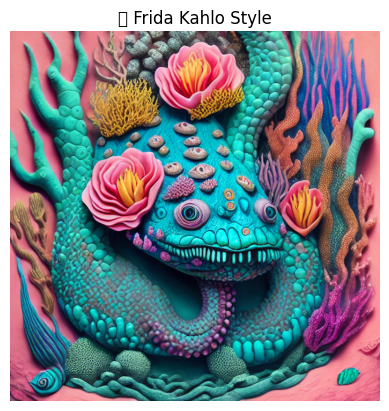

📝 Final Prompt:
 A hidden underwater kingdom ruled by sea serpents, captured in the essence of Frida Kahlo's style. Emphasized artistic traits include: Image: Frida_Kahlo_77.jpg
Description: Floral artwork, vibrant and bold color palette, close-up view, soft chalk pastel texture, contrasting dark background, conveying a sense of natural beauty and tranquility.. Image: Frida_Kahlo_5.jpg
Description: Surrealist portrait, intense gaze, earth-toned skin, surrounded by dense foliage, dreamlike realism, delicate yet defined brushstrokes, intimate composition, subtly melancholic mood.. Image: Frida_Kahlo_68.jpg
Description: Expressionist portrait, close-up, ochre and sienna tones, somber mood, textured brushstrokes, dreamlike quality, surreal juxtaposition of faces and masks.. Image: Frida_Kahlo_81.jpg
Description: Portrait fragment in a naive style, terracotta skin tones and red accents, textured impasto brushstrokes, stylized floral background with heavy outlines, expression of quiet intens

In [30]:
# 10. A hidden underwater kingdom ruled by sea serpents
artist_name = "Frida Kahlo"
image, prompt_used = generate_image("A hidden underwater kingdom ruled by sea serpents", artist_name)
print("📝 Final Prompt:\n", prompt_used)
image.save("/kaggle/working/sea_serpents_kahlo_style.png")